In [11]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt
# use the letters:
# ... T for (T)emperature
# ... P for (P)ressure
# ... D for (D)ensity
# ... Q for vapor quality x
# ... C for specific heat

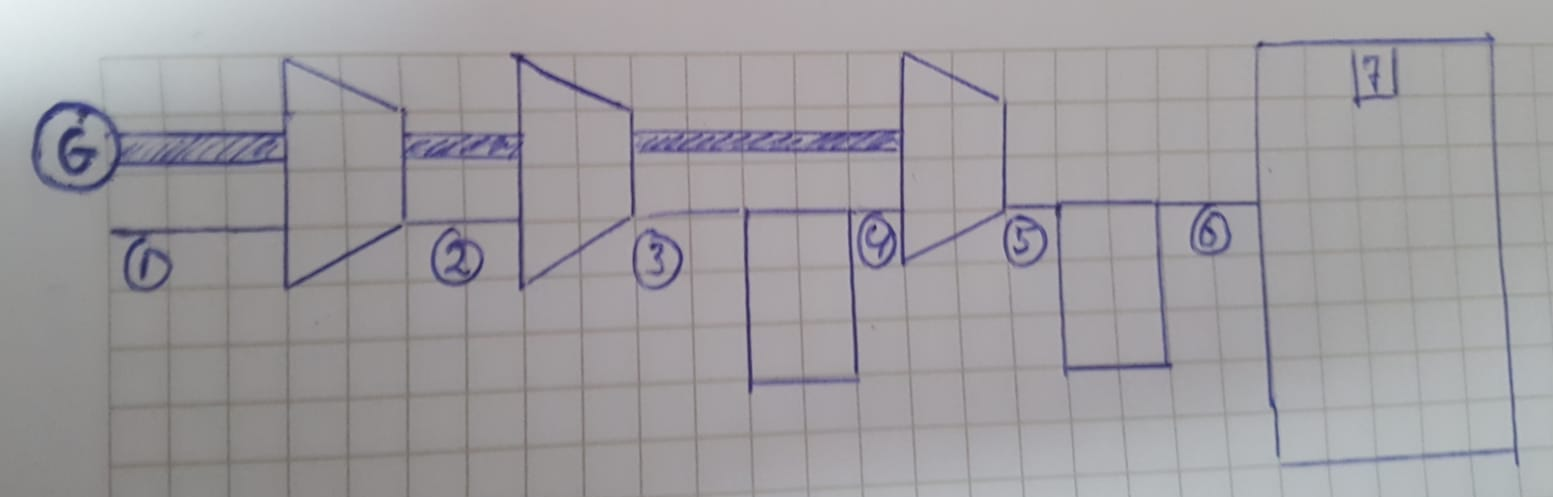

This means that p7 = p6 = p5, in this model p5 will be refered to as p7 <br>
In addition, the first 2 compressors have a fixed pressure ratio while the third is variable.

In [13]:
#Boundary conditions

#Ambiant air
p1 = 1.03e5    #Pa        
T1 = 11+273.15 #K

#Ideal heat exchanger functionality
T4 = T1
T6 = T1

#Fixed temperatures of hot & cold TES
Twh = 95+273.15 #K
Twl = T1

#Fixed pressures
p2 = 13*p1
p3 = 3.51*p2
p4 = p3


#Miscellaneous           
R = 8.3145      #J / mol K  
Mm = 28.97e-3   #kg/mol
Ra = R/Mm       #J/kgK
cv = 718        #J/ kg K      TBD, used???
dt =1           #s
t_rampup = 5*60 #s
Pwind = 100e6   #W

#Cavern
V = 50000    # m^3          TBD
pmax = 100e5 # Pa      
pmin = 60e5  # Pa

#Power conversion
eff_m = 0.98 #[-]
eff_g = 0.98 #[-]

#Compressor
eff_c   = 0.9 #[-]

#Turbine
eff_t   = 0.9 #[-]

#Initial pressure in cavern
p7 = pmin

#Might have to be deleted depending on the temperature calculation
gamma=1.37


In [14]:
#Functions

#Input power, including start up time compressor, without eff_m
def Pin(t):
    if t > t_rampup:
        Pin = Pwind
    else:
        Pin = Pwind*t/t_rampup
    return Pin


#Get temperature after compression including efficiency
def Tpressurize(Tin, pin, pout, eff_c=1):
    # eta_c = (h1s - h0)/ (h1 - h0)
    h0 = PropsSI("H", "P", pin, "T", Tin, "air")
    # s1,s = s0 (isentropic)
    s0 = PropsSI("S", "P", pin, "T", Tin, "air")
    s1s = s0
    h1s = PropsSI("H", "S", s1s, "P", pout, "air")

    h1 = h0 + 1/eff_c * (h1s - h0) # if eff_c = 1 should give same result as Tpres() function

    T1 = PropsSI("T", "H", h1, "P", pout, "air")
    return T1


#Get temperature after expansion including efficiency
def Tdepressurize(Tin, pin, pout, eff_t):
    # eta_t = (h0 - h1)/ (h0 - h1s)
    h0 = PropsSI("H", "P", pin, "T", Tin, "air")
    # s1,s = s0
    s0 = PropsSI("S", "P", pin, "T", Tin, "air")
    s1s = s0
    h1s = PropsSI("H", "S", s1s, "P", pout, "air")

    h1 = h0 - eff_t * (h0 - h1s) # if eff_t = 1 should give same result as Tpres() function

    T1 = PropsSI("T", "H", h1, "P", pout, "air")
    return T1

#Function for temperature after (de)compression
def Tcompr(pin,pout,Tin):
    Tout_s=Tin*(pout/pin)**((gamma-1)/gamma)
    Tout = Tin + (Tout_s-Tin)/eff_c
    return Tout


#Get enthalpy for known T,p
def hTp(p,T):
    return PropsSI("H","P",p,"T",T,"air")


# mass flow as a function of time
def mdot_in(t, p7):
    if p7 < pmax:
        
        #Specific work, dh3 is a function of time as p7 is a depended on time
        dh1 = hTp(p2,T2)-hTp(p1,T1)
        dh2 = hTp(p3,T3)-hTp(p2,T2) #possibly add dh1 and dh2 to cancel htp(p2,T2) to increase computation speed
        dh3 = hTp(p7,T5)-hTp(p4,T4)

        return (Pin(t)*(eff_c*eff_m))/(dh1+dh2+dh3)
    
    #If the pressure is at its max, no flow is possible
    else:
        return 0

def Q_HX(Tin,Tout):
    Tav = (Tin+Tout)/2
    cp = PropsSI('C','T',Tav,'P',p7,'air')
    Qdot = mdot*cp*(Tout-Tin)
    return Qdot

def flow_cooling_liquid(Tin,Tout):
    cp = PropsSI('C','T',(Twh+Twl)/2,'P',p1,'water')
    mflow = -Q_HX(Tin,Tout)/cp/(Twh-Twl)
    return mflow
    


/Users/jasper/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


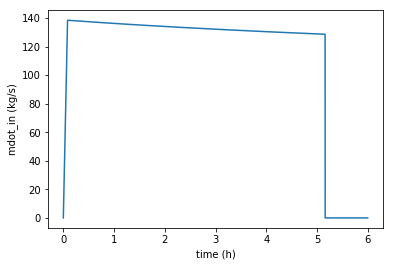

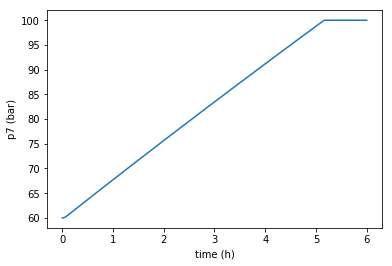

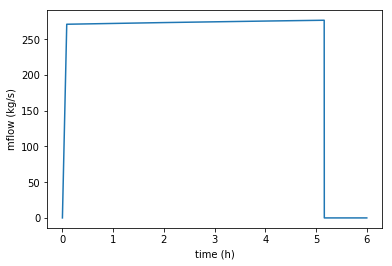

In [15]:
#Fill cavern and show various graphs 
x = []
y = []
z = []
mflow = []    
tmax=6*60*60

#Calculate Temperature after compressor stage, needed for enthalphy
#Outside of loop due to fixed p_ratio therefore fixed temperatures
T2=Tcompr(p1,p2,T1)
T3=Tcompr(p2,p3,T2)

for t in np.linspace(0, tmax, tmax/dt):
            
    #Calculate Temperature after compressor stage, needed for enthalphy
    T5=Tcompr(p4,p7,T4)
    
    mdot = mdot_in(t,p7)
    p7 += mdot * dt * Ra * T6 / V
    
    mflow.append(flow_cooling_liquid(T3,T4)+flow_cooling_liquid(T5,T6))
    
    x.append(t/60/60)
    y.append(mdot_in(t,p7))
    z.append(p7/1e5)
    #Tout.append(Tcompr(p7))
    
plt.plot(x, y)
plt.xlabel("time (h)")
plt.ylabel("mdot_in (kg/s)")
plt.show()

plt.plot(x,z)
plt.xlabel("time (h)")
plt.ylabel("p7 (bar)")
plt.show()

plt.plot(x,mflow)
plt.xlabel("time (h)")
plt.ylabel("mflow (kg/s)")
plt.show()

    

In [6]:
#Everything below obsolete???

In [7]:
#Function to fill the cavern
def fill_cavern(tmax):
    
    #Required argument for python while loop
    global p_cavern
    global m
    global t
    comp = True
    
    #Fill cavern until full or no more power (tmax is max time there is power)
    while p_cavern < pmax and t < tmax:
        
        #Determine required pressure ratio
        p_ratio = (p_cavern/p0)**(1/2) + p_loss

        #Determine mass in cavern
        m += mdot1(p_ratio, comp)*dt

        #Determine pressure in cavern
        p_cavern = m*R/Mm*T0/V
    
        t += dt
    if t < tmax:
        print('Not all this power can be stored, {0:.1f}% can not be used!'.format((1-t/tmax)*100))
        print("It took {0:.2f} hours to fill the cavern.".format(t/3600))
    else:
        print("No more power available.")
        
    print("Now the pressure is {0:.2f} bar".format(p_cavern/1e5))
    t=0
#Work in progress functions
def empty_cavern(tmax):
    global p_cavern
    global m
    global t
    comp = False
    
    while p_cavern > 2*p0 and t < tmax:
        p_ratio = (p0/p_cavern)**(1/2)
        m -= Pout/eff_t/(W1(p_cavern, p_ratio, T0, comp)+W1(p_cavern*p_ratio, p_ratio, T0, comp))
        p_cavern = m*R/Mm*T0/V
    
        t += dt
    
    if t < tmax:
        print("No more power available, ran out at {0:.2f} hours.".format(t/3600))
    else:
        print("Not out of energy :).")
        
    print("Now the pressure is {0:.2f} bar".format(p_cavern/1e5))
    t=0

In [8]:
#Reset conditions
p_cavern = p0
m = m0
t = 0

NameError: name 'p0' is not defined

In [ ]:
#First fill for x hours
fill_cavern(3600*1)

In [ ]:
#Second fill for y hour(s)
fill_cavern(3600*0.5)

In [ ]:
#Extracting energy from cavern
empty_cavern(3600*0.1)

In [ ]:
#Extracting energy from cavern
empty_cavern(3600*0.05)